## Setup

In [3]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

import pandas as pd

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [1]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [30]:
data = pd.read_csv("classified_spam.csv")
# text = data["text"]
# is_spam = data["label_num"]
# text_class = data["classification"] 

TEXT_COLUMN = 'text'
LABEL_COLUMN = 'label_num'

def df_to_tf_dataset(df, text_column, label_column):
    return tf.data.Dataset.from_tensor_slices((
        df[text_column].values,  # Features
        df[label_column].values   # Labels
    ))
    
dataset = df_to_tf_dataset(data, TEXT_COLUMN, LABEL_COLUMN)

train_size = int(len(data) * 0.8)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# Specify output types
train_dataset = train_dataset.map(lambda x, y: (x, y))  # Map to appropriate data types
test_dataset = test_dataset.map(lambda x, y: (x, y))  # Map to appropriate data types

Initially this returns a dataset of (text, label pairs):

In [15]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"Subject: enron methanol ; meter # : 988291\r\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nactivity you can obtain from gas control .\r\nthis change is needed asap for economics purposes ."
label:  b'ham'


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [16]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [31]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [32]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Good afternoon, my love ! Any job prospects ? Are you missing me ? What do you do ? Are you being lazy and bleak, hmmm ? Or happy and filled with my love ?'
 b"+123 Congratulations - in this week's competition draw u have won the 1450 prize to claim just call 09050002311 b4280703. T&Cs/stop SMS 08718727868. Over 18 only 150ppm"
 b"Subject: hoston hoop - it - up 6 weeks away !\r\ndear daren :\r\ndid you mark on your sporting event calendar to be in houston on may 5 th -\r\n6 th at greenspoint mall for the largest 3 - on - 3 basketball action in the\r\ncountry ? ? ? with less than 6 weeks until the entry deadline of april 25 th , the\r\nhoop - it - up staff is gearing up and coming to town !\r\nyou should have received your entry form if you have played in the houston\r\nevent in the past but if not , please contact our local hotline at\r\n713 - 521 - 4535 and our representative will take care of you right away . ? you\r\ncan also visit any houston - area foot locker or army r

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [19]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [20]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'of', 'to', 'and', 'a', 'in', 'for', 'is',
       'you', 'i', 'on', 'this', 'be', 'that', 'ect', 'will', 'with',
       'are'], dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [21]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[663,   1,   1, ...,   0,   0,   0],
       [179,   1,   1, ...,   0,   0,   0],
       [141,   6, 302, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [22]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Dear Voucher Holder, To claim this weeks offer, at you PC please go to http://www.e-tlp.co.uk/expressoffer Ts&Cs apply. To stop texts, txt STOP to 80062'
Round-trip:  dear [UNK] [UNK] to claim this weeks offer at you [UNK] please go to [UNK] [UNK] [UNK] to stop texts [UNK] stop to [UNK]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

Original:  b'Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min'
Round-trip:  want [UNK] [UNK

## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [33]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [34]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [35]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
print(sample_text)
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.


ValueError: Invalid dtype: str3328

Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [27]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

ValueError: Invalid dtype: str256000

Compile the Keras model to configure the training process:

In [36]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [37]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.7977 - loss: 0.6209 - val_accuracy: 0.8089 - val_loss: 0.4432
Epoch 2/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.8372 - loss: 0.3253 - val_accuracy: 0.9359 - val_loss: 0.1761
Epoch 3/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.9362 - loss: 0.1653 - val_accuracy: 0.9453 - val_loss: 0.1420
Epoch 4/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.9514 - loss: 0.1256 - val_accuracy: 0.9479 - val_loss: 0.1319
Epoch 5/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.9566 - loss: 0.1057 - val_accuracy: 0.9547 - val_loss: 0.1145
Epoch 6/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.9689 - loss: 0.0854 - val_accuracy: 0.9594 - val_loss: 0.1050
Epoch 7/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.9725 - loss: 0.0762 - val_accuracy: 0.9573 - val_loss: 0.0999
Epoch 8/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.9763 - loss: 0.0665 - val_accu

In [38]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9672 - loss: 0.0823
Test Loss: 0.08428523689508438
Test Accuracy: 0.968128502368927


(0.0, 0.5852736962959171)

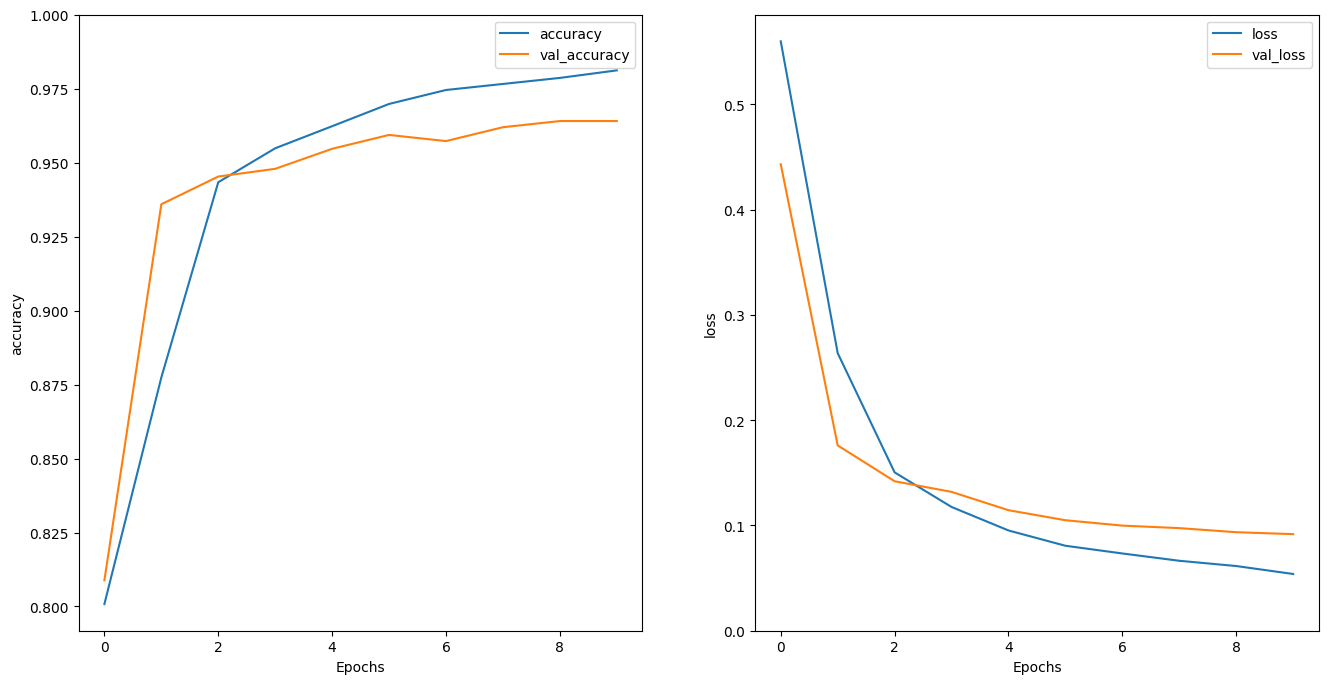

In [39]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [40]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

ValueError: Invalid dtype: str3328

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [41]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [42]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [44]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 689s 3s/step - accuracy: 0.9538 - loss: 0.1349 - val_accuracy: 0.9516 - val_loss: 0.1247
Epoch 2/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 659s 3s/step - accuracy: 0.9635 - loss: 0.1049 - val_accuracy: 0.9536 - val_loss: 0.1269
Epoch 3/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 720s 3s/step - accuracy: 0.9690 - loss: 0.0878 - val_accuracy: 0.9609 - val_loss: 0.1062
Epoch 4/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 750s 3s/step - accuracy: 0.9765 - loss: 0.0765 - val_accuracy: 0.9609 - val_loss: 0.1080
Epoch 5/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 750s 3s/step - accuracy: 0.9756 - loss: 0.0761 - val_accuracy: 0.9531 - val_loss: 0.1319
Epoch 6/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 701s 3s/step - accuracy: 0.9699 - loss: 0.0917 - val_accuracy: 0.9688 - val_loss: 0.0922
Epoch 7/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 1689s 7s/step - accuracy: 0.9789 - loss: 0.0630 - val_accuracy: 0.9708 - val_loss: 0.0891
Epoch 8/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 690s 3s/step - accuracy: 0.9829 - loss: 0.0579 - val_acc

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
